# <center/> MICRO-452 - Basics of Mobile Robotics

### <center/> Thymio Robot Project

#### <center/> Group 17

---

**<p style='text-align: center;'> Group members & Sciper</p>**

<center/> Kilian Pouderoux 310621
<center/> Matas Jones 313222
<center/> Gautier Demierre 340423
<center/> Geoffroy Renaut 326346

**<p style='text-align: center;'> Teacher</p>**

<center/> Prof. Francesco Mondada

**<p style='text-align: center;'> Due date</p>**

<center/> 05.12.2024

---


## Demonstration Video

<div style="text-align: center">
<video width="800" height="450" controls>
    <source src="Thymio_project_video.mp4" type="video/mp4">
</video>
<figcaption>Video: Project demonstration.</figcaption>
<br>

</div>

## Table of Contents

<ol type="I" style="list-style-position: inside;">
<li>Introduction</li>
<li>Libraries</li>
<li>Variable definitions</li>
<li>Computer vision</li>
<li>Global Navigation</li>
<li>Motion Control</li>
<li>Local Navigation</li>
<li>Kalman Filter</li>
<li>Conclusion</li>
<li>Main</li>
<li>Bibliography</li>
</ol>


## 1. Introduction


As part of the "Basics of mobile robotics, MICRO-452" course, we undertook a project putting together a large variety of different concepts learned during the lectures and practice sessions. The following goals had to be achieved in order to complete this project. <br>
•⁠ ⁠Map creation : the robot has to create a map of its environment<br>
•⁠ ⁠Pathfinding : the thymio robot has to find a trajectory through a complex environment that has been previously scanned. <br>
•⁠ ⁠Motion control : the robot is able to follow the previously found trajectory. <br>
•⁠ ⁠Obstacle avoidance : the robot is capable to avoid new obstacles placed in its path and go back to its former behaviour.<br>


### Objectives


In our project, a thymio goes from an initial position to "recover" objects at red-colored points while avoiding walls. It then has to go back to its initial position once the point has been visited. One should be able to place obstacles on its path and the Thymio should avoid them and go back to its task.<br>


### Environment


The map is two A0 white pieces of paper where differents obstacles and goals are placed. The black walls, are impossible to cross, the red-colored dot is the target.

<center> Example of a possible map </center>


<div style="text-align: center;">
<img src="map_exemple.jpeg" alt="Map example" title="Map example" width="500"/>
</div>

## 2. Libraries


In [1]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop
import cv2 
import sys

from CV_utils import *

In [2]:
# Initiate the communication between the Thymio and the computer
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock() 

Node 47693a04-0b6a-4e1f-bcfa-ab642b293fc0

## 3. Variable definitions


In [3]:
#### Thymio variables ####
L = 0.094
small_angle = 0.6 # rad
TURN_ANGLE = 0.05
ACCEPTABLE_DIST = 0.03
SPEED_CONVERSION = 3520

# angle PID controller variables:
KP = 150
KI = 0.2
KD = 0.001

MAX_ERROR_SUM = 5.0

V_NOMINAL_LEFT = 200
V_NOMINAL_RIGHT = 200
V_TURN = 150

#### Local nav variables ####
MOTOR_SPEED = 100
SHIFT = 0
PROX_THR_1 = [2000,2000,2000,2000,2000]
PROX_THR_2 = [500,500,500,500,500]

STEP_LENGTH_1 = 0.16
STEP_LENGTH_2 = 0.2

LEFT = 1
RIGHT = 0

STOP_SPEED = 0
SMALL_ANGLE_LOCAL = 0.4 # rad

#### GLOBAL NAV ####
GLOBAL_PT_MIN_DIST = 70

#### FSM variables ####
LOCAL_NAV = 1
GLOBAL_NAV = 0



#### CAMERA VARIABLES
CONVERSION_M_PER_PX_x = 0.0030
CONVERSION_M_PER_PX_y = 0.0010



YELLOW_PIK = (38, 196, 236)
BURNT_ORANGE = (204, 85, 0)


## 4. Computer vision


In [4]:
# class definitions and starting the cam, see CV_utils.py for the whole class and functions
cap = cv2.VideoCapture(0)
grilles = Grid()

2024-12-05 18:37:35.585 python[60783:5054942] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Once the camera is up and running, we have to go through several steps before entering the main part of the program :

- detect the anchors : 4 pink squares that define the region of interest
- detect the color circles which correspond to the targets the robot has to reach
- detect the obstacles the robot has to avoid
- detect the robot to get its initial position

The detection of the circles and the obstacles is run continuously until we detect these object several times, in order to average the measures to avoid incorrect detections.
If the detection takes too much time (>6s), because of incorrect detections or missing objects, the process restarts by itself until everything is detected.

Once these fixed objects are detected, we set the grid accordingly and we can then try to detect the robot. The while loop is at the center of the program and gets a frame for each iteration. The robot detecting function is then called : we give it the frame and it returns the annotated frame + the robot position and angle.

Another functions runs in parallel to check if the robot has reached the target, by comparing their centers


### Image processing


In [5]:
# Define the list of boundaries
colors = {
    'yellow': ([0, 123, 240], [41, 255, 255], -5, [0, 255, 255]), #2, -5
}

filename = "test.png"
frame = cv2.imread(filename)

if frame is None:
    print(f"The image {filename} could not be read.")
    sys.exit()

The pipeline of image processing for object detection is the following :

- once the hsv frame is obtained, we apply a gaussian blur to prepare the image for edge detection and median blur to reduce the noise
- we create a mask with the range of hsv values defined for the color we want to detect. The tuning of the ranges is an important step done before the demonstration. For this we use the function calib_hvs.py in which we can experiment different values for H,S and V thresholds.
- we apply a closing operation : dilation to fill the small holes then erosion to set it back to the right size and remove tiny regions `[1]`
- cv2.connectedComponentsWithStats to get the continous objects `[2]`
- cv2.findContours to get the contours of the detected objects

This methods allows even small regions are detected and identified as contours. Hence, depending on the object, we apply conditions on the number of edges and the area. It allows to differentiate between noisy regions where a false object could be detected and the real object.

In this example, the thresholding is almost perfect as we don't see any other region in the masks.


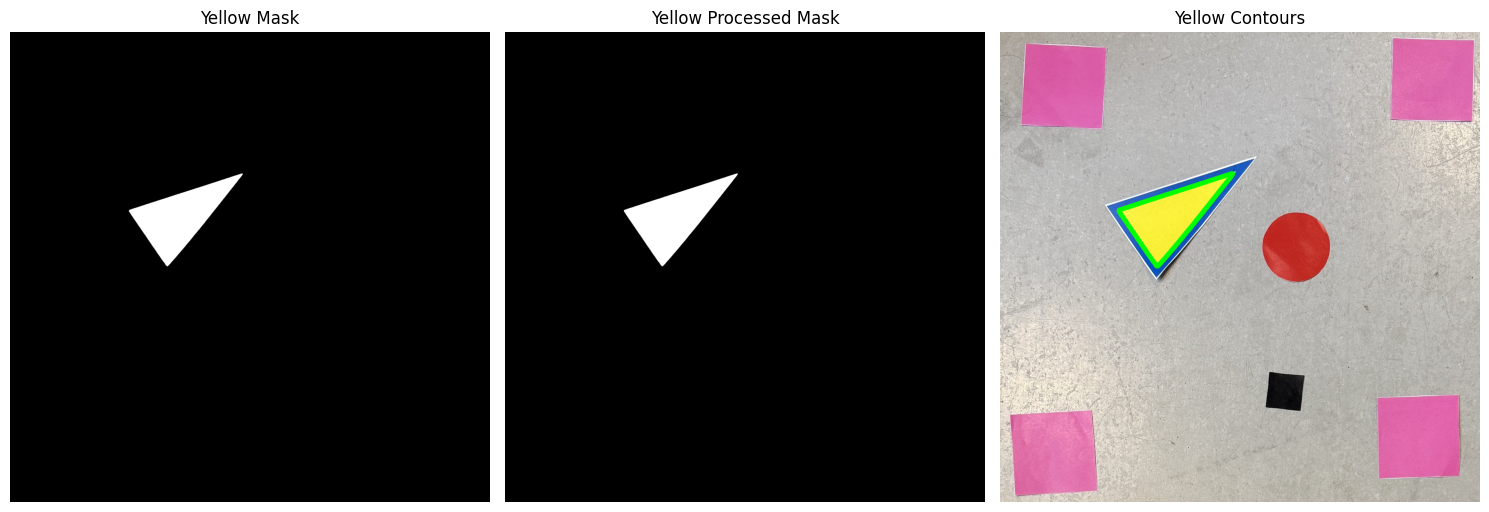

In [6]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
hsv = cv2.GaussianBlur(hsv, kernel_size, 0)
hsv = cv2.medianBlur(hsv, 5)
kernel = np.ones(kernel_size, np.uint8)

color_name = 'yellow'
lower, upper, _, display_color = colors[color_name]
lower = np.array(lower, dtype=np.uint8)
upper = np.array(upper, dtype=np.uint8)

mask = cv2.inRange(hsv, lower, upper)
dilation = cv2.dilate(mask, kernel, iterations=2)
erosion = cv2.erode(dilation, kernel, iterations=2)

num_labels, labels = cv2.connectedComponents(erosion)

contour_image = frame.copy()

for label in range(1, num_labels):  # label 0 is the background
    component_mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(contour_image, contours, -1, GREEN, thickness=20)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(mask, cmap="gray")
axes[0].set_title(f"{color_name.capitalize()} Mask")
axes[0].axis("off")

axes[1].imshow(erosion, cmap="gray")
axes[1].set_title(f"{color_name.capitalize()} Processed Mask")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
axes[2].set_title(f"{color_name.capitalize()} Contours")
axes[2].axis("off")

plt.tight_layout()
plt.show()


When we try to detect the black polygon, representing an obstacle, we are most interested in the convex hull of the polygon. Considering this hull is benefic for us because it will avoid the robot falling in traps inside the hull.
Before getting this hull, we want to enlarge the polygon to add some margin on the sides of the polygon, so that the robot can smoothly avoid the obstacle.
This is done with this function, which computes the normals of the faces at each vertex.

<font size="1">

```python

def enlarge_polygon(vertices, margin=15):
    enlarged_vertices = []
    num_vertices = len(vertices)

    for i in range(num_vertices):
        # for each vertex, get the previous and next vertex, then the edge vectors and the normal
        prev_idx = (i - 1) % num_vertices
        next_idx = (i + 1) % num_vertices

        edge1 = vertices[i] - vertices[prev_idx]
        edge2 = vertices[next_idx] - vertices[i]

        edge1_normalized = np.array([-edge1[1], edge1[0]], dtype=np.float64)
        edge2_normalized = np.array([-edge2[1], edge2[0]], dtype=np.float64)

        edge1_normalized /= np.linalg.norm(edge1_normalized)
        edge2_normalized /= np.linalg.norm(edge2_normalized)

        normal = 0.5*(edge1_normalized + edge2_normalized)
        enlarged_vertex = vertices[i] + margin * normal
        enlarged_vertices.append(enlarged_vertex)

    return np.array(enlarged_vertices, dtype=np.int32)

```

</font>

<div style="text-align: center;">
<img src="convex_hull.png" alt="Convex hull example image" title="Convex hull example image" width="300"/>
</div>

Using a triangle to represent the robot allows us to get both the position and the robot orientation. The triangle is designed in a way that the smallest side is the one opposing the tip of the triangle.
By computing the center of this side and the center of the full triangle, we get a line joining the front vertex and the midpoint of the back side. We can then compute its orientation.


<div style="text-align: center;">
<img src="triangle_robot.png" alt="Triangle example image" title="Triangle example image" width="500"/>
</div>

### Spaces


We are working with 3 different spaces :

- the frame (where the robot is detected and to display on the screen)
- the grid (the discretized space in which the path is computed)
- the physical world (where the thymio evolves)

These spaces interact with each other throughout the code, depending on the inputs and outputs needed by the different components.

- The link frame <-> grid is a simple mapping, done with the function map_range from CV_utils
- The link grid <-> physical world is done with the conversion factors, from px to meters


To enhance performances, we do not want to apply our image processing techniques on the whole frame captured by the camera. This is why we use the 4 square anchors that define the region of interest. Once they are detected, we are sistematically cropping the frame to the defined region.
While setting up the scene, we pay attention to dispose the anchors in a rectangular pattern, so we don't need to reorient the frame with a transformation.

<div style="text-align: center;">
<img src="cropped_process.png" alt="Cropping process example" title="Cropping process example" width="700"/>
</div>


In order to avoid the detection errors occuring while detecting the objects, we smooth the values obtained by doing an average on the positions and shapes of the objects.

- For the robot : we take the average of the last 2 detections and we assume that the robot is not moving super fast so once it's detected in a speific region, it will stay in a certain circle around its last position.
- For the circles : we have to detect each circle 20 times to set their position and radii.
- For the obstacles : each obstacle has to be detected at least 10 times to ensure that we got its vertices correctly

Once the circles, the obstacles and the initial position of the robot have been detected, we can pass the obstacle grid and the different positions to the rest of the code.


## 5. Global Navigation


In [7]:

def heuristic(a, b):
    # Compute the heuristic of the distance in manhattan, divided by 2 because of the possible neighboring cells
    return abs(a[0] - b[0]) + abs(a[1] - b[1])/2


def find_global_path(map_grid, start, target):

    # Initialize the open set as a priority queue and add the start node
    open_set = []
    heappush(open_set, (heuristic(start, target), 0, start))  # (f_cost, g_cost, position)

    came_from = {}
    # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
    g_costs = {start: 0}
    explored = set()

    while open_set:
        
        # Pop the node with the lowest f_cost from the open set
        current_f_cost, current_g_cost, current = heappop(open_set)

        # Test for arrival at destination
        if current == target:
            break

        # Get the adjacent cells of the current one
        neighboring_cells = [
            (current[0]-1, current[1]),  
            (current[0]+1, current[1]),  
            (current[0], current[1]-1),  
            (current[0], current[1]+1),  
            (current[0]-1, current[1]-1),
            (current[0]+1, current[1]+1),
            (current[0]+1, current[1]-1),
            (current[0]-1, current[1]+1),


            (current[0]-2, current[1]),  
            (current[0]+2, current[1]),  
            (current[0], current[1]-2),  
            (current[0], current[1]+2),   
            (current[0]-1, current[1]-2),  
            (current[0]+1, current[1]+2),  
            (current[0]+1, current[1]-2),  
            (current[0]-1, current[1]+2),
            (current[0]-2, current[1]-1),  
            (current[0]+2, current[1]+1),  
            (current[0]+2, current[1]-1),  
            (current[0]-2, current[1]+1)
        ]

        for neighbor in neighboring_cells:

            # check if neighbor is in the grid, not an obstacle, and not already explored
            if (0 <= neighbor[0] < map_grid.shape[0]) and (0 <= neighbor[1] < map_grid.shape[1]) and (map_grid[neighbor[0], neighbor[1]] >= -1) and (neighbor not in explored):
                
                tentative_g_cost = current_g_cost +1

                # try to find a lower cost
                if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                    
                    # Update came_from, g_costs, and f_cost
                    came_from[neighbor] = current
                    g_costs[neighbor] = tentative_g_cost
                    f_cost = tentative_g_cost + heuristic(neighbor, target)

                    # Add neighbor to open set
                    heappush(open_set, (f_cost, tentative_g_cost, neighbor))

        # the current cell is now explored 
        explored.add(current)
        

    # Reconstruct path
    if current == target:
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(start)

        # get the reversed path
        reversed_path = []
        for i in range(len(path)):
            reversed_path.append(path[len(path)-i-1])
    
        return reversed_path
    else:
        return None


# Function to compute the angle between two vectors (in radians)
def angle_between_vectors(v1, v2):
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    
    mag_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
    mag_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
    
    cos_theta = dot_product / (mag_v1 * mag_v2)  # Cosine of the angle between the vectors
    cos_theta = max(-1, min(1, cos_theta))  # saturate the value to prevent math domain error
    
    return math.acos(cos_theta)

def clear_path(path, direction_change_threshold=0.45):
    new_path = []
    last_path_pos = 0
    new_path.append(path[last_path_pos])  # Always keep the first point

    for i in range(1, len(path) - 1):
        x1, y1 = path[last_path_pos]
        x2, y2 = path[i]
        x3, y3 = path[i + 1]

        dist = math.dist((x1, y1), (x2, y2))

        # We get the two consecutive vectors
        vector1 = (x2 - x1, y2 - y1) 
        vector2 = (x3 - x2, y3 - y2) 

        angle = angle_between_vectors(vector1, vector2)

        # If the angle is larger than the threshold, current point is added to new_path
        if angle > direction_change_threshold and dist > GLOBAL_PT_MIN_DIST:
            new_path.append(path[i])
            last_path_pos = i

    # Always add the last point
    new_path.append(path[-1])
    return new_path


In [8]:
class GlobalNav:

    def __init__(self, map, current_target):
        self.map = map
        self.current_target = current_target
        self.path = []
        self.obj_index = 0
        self.no_path = True


    def create_path(self, init_pos):
        # find the global by using a map, a target and a starting point
        path = find_global_path(self.map, init_pos , self.current_target)
        if path is None:
            sys.exit("No global path was found.")
        
        # reduce the number of waypoints
        reduced_path = clear_path(path)
        # converts the path from pixels to meters
        self.path = [tuple((x[0] * CONVERSION_M_PER_PX_x, x[1] * CONVERSION_M_PER_PX_y)) for x in reduced_path]
        
        return reduced_path

# 6. Kidnapping


For kidnapping, both values of x and y axis of the Thymio IMU are checked. If the values are above the threshold, the kidnapping state is triggered in the main.


In [9]:
def kidnapping():
    # check front proximity sensors
    for i in range(2):
        if list(node.v.acc)[i] > 18 :
            return True 
    return False

## 7. Motion Control

A controller class `thymio` was developped and incorporated in this project and is used to manage the movement of the Thymio. The FSM which consists mainly of the global and local navigation logic blocks decides the next state actions to perform and then instructs the thymio class to execute them. The FSM gives a final state objectif, a position or an angle, and leaves the thymio class deal with the intermediary steps to achieve this final state.

The two main functions in the thymio class are the `go_to_pos()` and the `turn_90()` functions. go_to_pos() is based on a PID controller who's objectif is to minimize an angle error. This error being the difference between the current Thymio angle and the desired angle. A PID controller was chosen as it is a compact, easy to implement and versatille controller `[4]`. As shown in the figure bellow, a PID controller incorporates `Proportional`, `Intergral` and `Derivative` elements to ouput a `corrective response` u(t) to a given error e(t). This output is used to modify the state of the system y(t) which is then used to calcuate the PID input e(t) = r(t) - y(t). This cycle is repeated until a desired state is achieved. This PID output is used to create differential drive and is based on the document “CS W4733 NOTES - Differential Drive Robots” from Dudek and Jenkin `[5]`. If the wheels of the Thymio turn at different rates, the Thymio will turn and advance or if absolute value of the angular velocities are the same but one is spinning in the opposite direction, the Thymio will turn on itself without changing position.

<div style="text-align: center;">
<img src="PID_block_diagram.jpeg" alt="PID block diagram" title="PID block diagram" width="500"/>
</div>

The PID output u(t) is calculated as follows:
$$u(t) = K_p*e(t) + K_i*\int_{0}^{t} e(t) dt \ + K_d*\frac{d}{dt} e(t)$$

A discrete version of the equation above is implemented in the angle_PID() function. It subsitutes the intergral with a sum and the continous deriavtive by the rate of change between two iterations. The PID weights $K_p$, $K_i$ and $K_d$ where found by tuning.

<font size="1">

```python
# Calculate the PID corrective input based on the error
def angle_PID(self, error, dt):
    self.error_sum = self.error_sum + error
    # Anti-windup of error sum
    if self.error_sum > MAX_ERROR_SUM:
        self.error_sum = MAX_ERROR_SUM

    if self.error_sum < -MAX_ERROR_SUM:
        self.error_sum = -MAX_ERROR_SUM

    # Compute PID value
    PID_value = self.Kp*error + self.Ki*self.error_sum + self.Kd*(error-self.previous_error)/dt
    self.previous_error = error

    return PID_value
```

</font>

The go_to_pos() function evaluates the direction in which the Thymio should turn based on its current position and the objectif position. As shown on the left figure bellow, the angle to correct, the error, is $delta = theta - phi$. Based on this error, the function will decide if the Thymio should turn on itself or should turn and advance and in which direction it shiould turn, clockwise or anti-clockwise. If the angle is bigger than an acceptable offset from the desired angle, the Thymio will turn without moving. Once the Thymio's angle is within this acceptable offset, it will start to advance whilst correcting the remaning angular error by incorporating the PID value for differential drive. It will continue to advance until it reaches an acceptable distance from the objectif and will then indicate to the FSM that it has reached its objectif and will be given a new one. The acceptable angular offset and accpetable distance were implemented to avoid oscillitory behavior where the Thymio would overshoot its current objectif, angular of positional, and would not accomplish its objectifs. The logic described above is illustrated in the right figure bellow and in the go_to_pos() function code bellow.

<div style="text-align: center;">
    <img src="thymio_angle_image.jpeg" style="margin-right:10px;" width="300">
    <img src="go_to_pos_image.jpeg" width="330">
</div>

<font size="1">

```python
def go_to_pos(self, objectif, small_angle): # objectif: x, y, theta
        d_angle = self.phi(objectif)
        turn_direction = self.direction_to_turn(d_angle)
        error = thymio.correct_angle_error(d_angle-self.theta)
        PID_value = abs(self.angle_PID(error))
        dist = math.dist((self.x, self.y),objectif)

        if  dist < ACCEPTABLE_DIST: # Arrived at position?
            return True

        # turn and advance
        if abs(error) < small_angle or abs(error) > 2*math.pi - small_angle:
            # print("Small angle")
            self.V_left = thymio.convert_speed(V_NOMINAL_LEFT+turn_direction*PID_value)
            self.V_right = thymio.convert_speed(V_NOMINAL_RIGHT-turn_direction*PID_value)

        # turn only
        else:
            # print("Big angle")
            self.V_left = thymio.convert_speed(V_TURN*turn_direction)
            self.V_right = thymio.convert_speed(-V_TURN*turn_direction)

        return False

```

</font>

The `turn_90()` function uses similar logic as the go_to_pos() function and is used to turn 90° which is necessary for the local navigation. The Thymio will turn on itself until it has reached an acceptable angle within an offset range of the desired angle.


In [10]:
class thymio:

    def __init__(self, Kp, Ki, Kd):
        self.x = 0
        self.y = 0
        self.theta = 0
        self.V_left = 0
        self.V_right = 0
        self.V_avg = 0
        self.omega = 0

        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.error_sum = 0
        self.previous_error = 0

    ### GENERAL THYMIO UTILITIES ###
    def convert_speed(thymio_motor_speed):
        return thymio_motor_speed/SPEED_CONVERSION
    
    
    def motors(self, left_speed, right_speed):
        left_speed= int(SPEED_CONVERSION*left_speed)
        right_speed = int(SPEED_CONVERSION*right_speed)
        return {
            "motor.left.target": [left_speed],
            "motor.right.target": [right_speed]
        }
        

    def update_thymio(self):
        self.omega = (self.V_left-self.V_right)/L
        self.V_avg = (self.V_left+self.V_right)/2


    def estimate_state(self, estimated_state):
        self.x = estimated_state[0]
        self.y = estimated_state[1]
        self.theta = estimated_state[2]


    def limit_theta(self):
        if self.theta > 2*math.pi:
            self.theta -= 2*math.pi
        elif self.theta < 0:
            self.theta += 2*math.pi


    ### THYMIO ANGLE CALCULATOR ###
    def phi(self, objectif):
        phi = 0.0
        dx = objectif[0] - self.x
        dy = objectif[1] - self.y
        error_threshold = 0.0
        if dx > error_threshold:
            if dy > error_threshold:
                phi = math.atan(dy/dx) # phi_2
            elif dy < -error_threshold:
                phi = 2*math.pi + math.atan(dy/dx) # phi_4
            else:
                phi = 0 # phi_3 

        elif dx < -error_threshold:
            if dy > error_threshold:
                phi = math.pi + math.atan(dy/dx) # phi_8
            elif dy < -error_threshold:
                phi = math.pi + math.atan(dy/dx) # phi_6
            else:
                phi = math.pi # phi_7

        else:
            if dy > 0:
                phi = math.pi/2 # phi_1
            else:
                phi = 3*math.pi/2 # phi_5

        return phi
    

    def direction_to_turn(self, phi):
        sigma = phi - self.theta
        if abs(sigma) < math.pi:
            return np.sign(sigma)
        else:
            return np.sign(-sigma)
        

    ### THYMIO CONTROL SCHEME ###
    def go_to_pos(self, objectif, small_angle, dt): # objectif: x, y, theta
        d_angle = self.phi(objectif)
        turn_direction = self.direction_to_turn(d_angle)
        error = thymio.correct_angle_error(d_angle-self.theta)
        PID_value = abs(self.angle_PID(error, dt))
        dist = math.dist((self.x, self.y),objectif)

        if  dist < ACCEPTABLE_DIST: # Arrived at position?
            return True 
        
        # turn and advance
        if abs(error) < small_angle or abs(error) > 2*math.pi - small_angle:
            # print("Small angle")
            self.V_left = thymio.convert_speed(V_NOMINAL_LEFT+turn_direction*PID_value)
            self.V_right = thymio.convert_speed(V_NOMINAL_RIGHT-turn_direction*PID_value)

        # turn only
        else:
            # print("Big angle")
            self.V_left = thymio.convert_speed(V_TURN*turn_direction)
            self.V_right = thymio.convert_speed(-V_TURN*turn_direction)
        
        return False
    

    def turn_to_angle(self, angle_obj):
        turn_direction = self.direction_to_turn(angle_obj)
        error = thymio.correct_angle_error(angle_obj-self.theta)
        if abs(error) < TURN_ANGLE or abs(error) > 2*math.pi - TURN_ANGLE:
            # print("Finished turning!")
            return True

        else:
            # print("Turning")
            self.V_left = thymio.convert_speed(V_TURN*turn_direction)
            self.V_right = thymio.convert_speed(-V_TURN*turn_direction)
            return False
            

    def angle_PID(self, error, dt):
        self.error_sum = self.error_sum + error
        if self.error_sum > MAX_ERROR_SUM:
            self.error_sum = MAX_ERROR_SUM

        if self.error_sum < -MAX_ERROR_SUM:
            self.error_sum = -MAX_ERROR_SUM

        PID_value = self.Kp*error + self.Ki*self.error_sum + self.Kd*(error-self.previous_error)/dt
        self.previous_error = error

        return PID_value


    def correct_angle_error(error):
        if abs(error) > math.pi:
            error = 2*math.pi - error*np.sign(error)
        return error
    
    def turn_90(self, init_angle, direction):
        if(direction == LEFT):
            angle_obj = self.adjust_angle(init_angle - (math.pi/2))
            error = angle_obj - self.theta
            if abs(error) < SMALL_ANGLE_LOCAL or abs(error) > 2*math.pi - SMALL_ANGLE_LOCAL:
                return True
            else:
                self.V_left = thymio.convert_speed(-V_TURN)
                self.V_right = thymio.convert_speed(V_TURN)
                return False
        elif(direction == RIGHT):
            angle_obj = self.adjust_angle(init_angle + (math.pi/2))
            error = angle_obj - self.theta
            if abs(error) < SMALL_ANGLE_LOCAL or abs(error) > 2*math.pi - SMALL_ANGLE_LOCAL:
                return True
            else:
                self.V_left = thymio.convert_speed(V_TURN)
                self.V_right = thymio.convert_speed(-V_TURN)
                return False
            
    def adjust_angle(self, angle):
        if angle < 0:
            angle += 2*math.pi
            return angle
        elif angle >= 2*math.pi :
            angle -= 2*math.pi
            return angle
        else :
            return angle

## 8. Local Navigation


<div style="display: flex; align-items: center;">
  <div style="flex: none; width: 60%; text-align: left;">
    <p>In order to be fully reactive, the state of the Thymio can be switched from global to local. This is necessary so that the robot's navigation system can adapt its trajectory if an obstacle suddenly appears. Since there is no proximity sensors on the side of the robot, implementing a PID to walk along the wall and get around the obstacle is not possible. We therefore decided to grope our way around the obstacle, in such way that bypassing of the obstacle is a matter of trial and detection. This was inspired by art.<code>[3]</code>. However, every movement of the robot is either parallel or perpendicular to the direction from which the robot was following initially. Turns on itself are 90 degrees. This system allows us to count the distance the robot deviates from the initial trajectory, so that it can return to the path once the obstacle has been avoided. That makes it simple, robust and efficient. Obstacle avoidance stages are 3. First <code>Deviate</code>, enables the robot to move aside until there's a free path to bypass the obstacle. Then <code>Bypass</code> takes the robot along the side of the obstacle until it has passed it. Finally, <code>Back_to_path</code> allow the robot to return to its initial path. There's a last state to allow transition from a state to another. In particular, it would transition back from <em>Back_to_path</em> to <em>Bypass</em> if additional iterations were required. To move, the algorithm calls on function of the Thymio class (<code>go_to_pos</code> and <code>turn_90</code>). For Local Navigation class, the function <code>avoid()</code> was designed to be reused at the several stages during avoidance process, simply changing given parameters. The switch from local to global is only done when the Thymio has returned to the initial path and no others obstacles are detected. The design of the algorithm allows to avoid obstacle with convex front surface, and convex side surface. Implementing local avoidance for concave surface would makes the code too complex, increasing the probability of error, and mainly doesn't make sense, since the thymio plays the role of a rugbyman avoiding the other players. You can see below a diagram of the different states of the local avoidance. <br><br> 
    <img src="Diagram.jpeg" alt="Diagramme" width="850"/> </p>
  </div>
  <div style="flex: 1; text-align: right; margin-right: 60px;">
    <img src="Local_Navigation.jpeg" alt="Image" style="width: 430px;"/>
  </div>
</div>


In [11]:
GO_DEVIATE = 1
GO_BYPASS = 2
END_LOCAL_NAV = 3

class LocalNav:
    def __init__(self, thymio_obj, avoidance_dir = RIGHT, stp_needed = True, stp_in_progress = False, obs_detected = False, go_for_detect = True, transit = GO_DEVIATE, x=0, y=0, shift = 0, init_angle = 0):
        self.thymio = thymio_obj
        self.local_nav_state = "Transit"                # Store the states of the Local Nav FSM 
        self.avoidance_direction = avoidance_dir        # Direction to bypass  
        self.step_needed = stp_needed                   # True if the turning lane isn't clear and we still need to move forward
        self.step_in_progress = stp_in_progress         # True if we are moving straight on
        self.obstacle_detected = obs_detected           # Used to avoid redoing local navigation initializations if an obstacle is still ahead.
        self.go_for_detection = go_for_detect           # Steps forward are done and it's time to see if the turning lane is free 
        self.transit_state = transit                    # Used to know which state to switch to
        self.objectif = [x, y]                          # Store the coordinates of the next step
        self.shift = shift                              # Counter to record the distance we deviate from the inital path
        self.initial_angle = init_angle                 # Store the angle at which we are before turning


    def obs_detection(self, threshold):
        for i in range(5):
            if list(node.v.prox.horizontal)[i] > threshold[i] :
                return True 
        return False
    

    def switch_initial_angle(self, dir):
        if dir == 1:
            self.initial_angle = self.thymio.adjust_angle(self.initial_angle - (math.pi/2))
        elif dir == 0:
            self.initial_angle = self.thymio.adjust_angle(self.initial_angle + (math.pi/2))
            

    def find_direction(self):
        prox_val = list(node.v.prox.horizontal)
        left = prox_val[0]+prox_val[1]+prox_val[2]
        right = prox_val[2]+prox_val[3]
        if left <= right:
            return LEFT
        else :
            return RIGHT


    def init_avoidance(self):
        if not self.obstacle_detected :
            if self.obs_detection(PROX_THR_1):
                self.local_nav_state = "transit"
                self.obstacle_detected = True 
                self.transit_state = GO_DEVIATE
                self.initial_angle = self.thymio.theta
                self.avoidance_direction = self.find_direction() 
                return True
            else :
                return False 
        else :
            return True  


    def avoid(self, avoid_Thr, count, next_case, step_length, dt):
        if self.step_needed :
            if not(self.step_in_progress):
                self.objectif[0] = step_length*math.cos(self.thymio.theta) + self.thymio.x
                self.objectif[1] = step_length*math.sin(self.thymio.theta) + self.thymio.y
                self.step_in_progress = True
            if(self.thymio.go_to_pos(self.objectif, SMALL_ANGLE_LOCAL, dt)):
                self.step_needed = False
                self.step_in_progress = False
                if count :
                    self.shift += 1
        else :
            if self.go_for_detection == True :
                if self.thymio.turn_90(self.initial_angle, not(self.avoidance_direction)):
                    self.switch_initial_angle(not(self.avoidance_direction))
                    if not self.obs_detection(avoid_Thr):
                        self.local_nav_state = next_case
                        self.step_needed = True 
                    else :
                        self.go_for_detection = False
                else :
                    self.step_needed = False
            else :
                if self.thymio.turn_90(self.initial_angle, self.avoidance_direction):
                    self.switch_initial_angle(self.avoidance_direction)
                    self.step_needed = True
                    self.go_for_detection = True


    def transit_run(self):
        if self.thymio.turn_90(self.initial_angle, self.avoidance_direction):
            self.switch_initial_angle(self.avoidance_direction)
            if self.transit_state == GO_DEVIATE:
                self.local_nav_state = "deviate"
            elif self.transit_state == GO_BYPASS:
                self.local_nav_state = "bypass"
            elif self.transit_state == END_LOCAL_NAV:
                self.transit_for_path = False 
                self.obstacle_detected = False
    
    
    def find_init_path(self, step_length, dt):
        if self.step_needed :
            if not(self.step_in_progress):
                self.objectif[0] = step_length*math.cos(self.thymio.theta) + self.thymio.x
                self.objectif[1] = step_length*math.sin(self.thymio.theta) + self.thymio.y
                self.step_in_progress = True
            if(self.thymio.go_to_pos(self.objectif, SMALL_ANGLE_LOCAL, dt)):
                self.step_needed = False
                self.step_in_progress = False
                self.shift -= 1
                if self.shift == 0 :
                    self.local_nav_state = "transit"
                    self.transit_state = END_LOCAL_NAV
                    self.step_needed = True 
        else :
            if self.obs_detection(PROX_THR_2):
                self.local_nav_state = "transit"
                self.transit_state = GO_BYPASS
                self.step_needed = True 
            else :
                self.step_needed = True 


    def run(self, frame, position, dt):
        if self.init_avoidance():
            match self.local_nav_state:
                case "deviate":
                    cv2.circle(frame, position[0], 15, RED, 5)
                    self.avoid(avoid_Thr = PROX_THR_1, count = True, next_case = "bypass", step_length = STEP_LENGTH_1, dt = dt)

                case "bypass":
                    cv2.circle(frame, position[0], 25, RED, 5)
                    self.avoid(avoid_Thr = PROX_THR_2, count = False, next_case = "back_to_path", step_length = STEP_LENGTH_2, dt = dt)

                case "transit":
                    cv2.circle(frame, position[0], 15, BLUE, 5)
                    self.transit_run()
                    
                case "back_to_path":
                    cv2.circle(frame, position[0], 25, BLUE, 5)
                    self.find_init_path(step_length = STEP_LENGTH_1, dt = dt)

                case _:
                    print("-------------------")
            
            return True
        else :
            return False 


await node.wait_for_variables({"prox.horizontal"}) 

## 9. Kalman Filter

An extended Kalman Filter (EKF) was implemented in this project as a means of improving the estimated state of the Thymio. The EKF combines positional and angular measurements from the camera and the velocity of the Thymio with state and measurement noise to achieve an increase in the accuracy of the state estimation.

Kalman filters are an interesting approach to state estimation as they require less memory and are generally faster than other filters such as the particle filter and the histogram filter. Furthermore, Kalman filters are able to incorporate the measurements and statistical proprieties from multiple sensors to generate better estimations. However they require strong assumptions such as gaussian noise and linear dynamical systems to work. EKFs are a variant of the Kalman filter which can be extended to non-linear systems `[6]`, `[7]`. The state space model of the Thymio, the model that describes the dynamic evolution of the system based on the previous state, the input and some eventual noise, is non-linear. For this reason, an EKF was implemented. Equation (1) gives the description of the dynamical system where the matrix B (eq.(2)) introduces the non-linearities from the cos() and sin() functions.

(1)

$$
\hat{x}_k = A_k * x_{k-1} + B_k * u_{k-1} + v
$$

(2)

$$
B_k = \begin{bmatrix}
cos(θ_{k-1})*dt & 0 \\
sin(θ_{k-1})*dt & 0 \\
0 & dt \\
\end{bmatrix}
$$

Here are the variables used in the EKF equations:

$\hat{x}_k$ : Estimated state<br>
$x_k$ : Current state<br>
$x_{k-1}$ : Previous state<br>
$u_{k-1}$ : Control input<br>
$P_k$ : Current covariance matrix <br>
$P_{k-1}$ : Previous covariance matrix <br>
$\hat{P}_k$ : Current covariance matrix estimation <br>
$A_k$ : State transition matrix<br>
$B_k$ : Control input matrix<br>
$v_k$ : Process noise<br>
$Q_k$ : Action uncertainty matrix <br>
$C_k$ : Measurement matrix <br>
$i_k$ : Innovation <br>
$w_k$ : Sensor error <br>
$S_k$ : Innovation covariance matrix <br>
$R_k$ : Sensor measurment noise covariance matrix <br>
$K_k$ : Near optimal Kalman gain <br>

The algorithm cycles through three steps: predict, measure and update. In the first step, the algorithm will use the state space model and the previous state, previous input and previous state covariance to estimate the current state (eq.(4)) and the current state covariance matrix (eq(5)).

(3)

$$
\hat{x}_k = x_{k-1} + V*cos(θ_{k-1})*dt
$$

$$
\hat{y}_k = y_{k-1} + V*sin(θ_{k-1})*dt
$$

$$
\hat{θ}_k = θ_{k-1} + ω*dt
$$

(4)

$$
\hat{x}_k = A_k * x_{k-1} + B_k * u_{k-1} + v_k
$$

(5)

$$
\hat{P}_k = A_k * P_{k-1} * A^T_k + Q_k
$$

The dynamics of the system are described in eq.(4) which is the matrix form of eq.(3) with the addition of estimation noise. This equation in itself could suffice to estimate the dynamics of the system. However, due to discrepancies between the ideal model and the actual Thymio such as wheel slipping and variations in motor velocities, the state estimitator will progressively loose in accuracy. To combat this issue, Kalman filters improve the posteriori state estimation by incorporating a measurement of the current state. The improved estimation is found by a weighted average of the state estimation and the measurement.

(6)

$$
i_k = z_k - C_k*\hat{x}_k + w_k
$$

(7)

$$
S_k = C_k * P_k * C^T_k + R_k
$$

(8)

$$
K_k = \hat{P}_k*C^T_k*S_k^{-1}
$$

The estimated state covariance (eq.(5)) and the observation covariance (eq.(7)) matrices are used to calculate the near optimal Kalman gain K (eq.(8)) which is then used to update the state estimation (eq.(9)) and the state covariance (eq.(10)).

(9)

$$
x_k = \hat{x}_k + K_k*i_k
$$

(10)

$$
P_k = (I-K_k*C_k)*\hat{P}_k
$$

This process of prediction, measurement and update is repeated for the duration of the task and allows for precise state estimations.

The EKF requires the initialization of multiple variables for it to work, notably the initial covariance matrix $P_0$, the process noise $v_k$, the sensor noise $w_k$, the action uncertainty matrix $Q_k$ and the sensor measurment noise covariance matrix $R_k$. In the setting of this task, the noise should be time independent. As a further simplification, the covariance matrices $Q_k$ and $R_k$ were taken to be diagonal and were found by performing variance tests. These tests measured the state estimation variance by comparing the estimated states and those found by physical state measurements. The objective of the first test was to measure the state variance in position. During this test, the Thymio received the order to advance 50cm after which, $\hat{x}$ and the physical measurement of x were compared and used to calculate the positional variance as shown in table (1.A). The variance in y was set to the same value as the variance in x. A similar test was done to estimate the angular variance. The Thymio was ordered to turn 135° and the angular estimations and physical measurements were used to compute the angular variance. The results of this test are given in the table below (1.B). $Δx$ and $Δθ$ are used to calculate the variance as they represent the variance between where the Thymio estimates it is and where it really is.

(T.1)

<center>

| Test A | $x$ [cm] | $\hat{x}$ [cm] | $Δx$  | Test B | $θ$ [deg] | $\hat{θ}$ [deg] | $Δθ$  |
| :----: | :------: | :------------: | :---: | :----: | :-------: | :-------------: | :---: |
|  A.1   |   50.3   |     49.02      | 1.28  |  B.1   |  135 ± 1  |     132.34      | 1.66  |
|  A.2   |   49.8   |     49.07      | 0.73  |  B.2   |  132 ± 1  |     135.71      | -4.71 |
|  A.3   |   49.1   |     49.20      | -0.10 |  B.3   |  130 ± 1  |     134.98      | -5.98 |
|  A.4   |   48.5   |     49.06      | -0.56 |  B.4   |  137 ± 1  |     134.39      | 3.61  |
|  A.5   |   49.7   |     49.25      | 0.45  |  B.5   |  134 ± 1  |     135.36      | -2.36 |
|  A.6   |   49.9   |     49.01      | 0.89  |  B.6   |  138 ± 1  |     135.12      | 3.88  |
|  A.7   |   48.8   |     49.24      | -0.44 |  B.7   |  131 ± 1  |     134.93      | -4.93 |
|  A.8   |   49.8   |     49.02      | 1.08  |  B.8   |  133 ± 1  |     135.48      | -3.48 |
|  A.9   |   50.1   |     49.36      | 0.74  |  B.9   |  130 ± 1  |     135.16      | -6.16 |
|  A.10  |   49.8   |     49.17      | 0.63  |  B.10  |  137 ± 1  |     135.05      | 2.95  |
|  A.11  |   50.0   |     49.22      | 0.58  |  B.11  |  138 ± 1  |     135.38      | 3.62  |
|  A.12  |   50.1   |     49.39      | 0.71  |  B.12  |  132 ± 1  |     134.76      | -3.76 |

</center>

The covariance matrix describes the variation of one variable with regard to the variation of another and can be found by using eq.(11) and eq.(12). As mentioned above, the covariance matrix was taken to be diagonal which means that the covariance matrix is equal to the variance matrix. Note that in reality the covariance matrix is not diagonal as the different variables do affect each other. This simplification was made as the camera will provide accurate measurements which will compensate for this covariance. The camera can be hidden for a certain duration, however this duration was estimated to be short enough that the state estimation would not loose too much accuracy. The values of the variance matrix $Q_k$ are: $Var(x) = Var(y) = 0.331 cm^2 = 3.31×10^{−5} m^2 $ and $Var(θ) = 16.74 deg^2 = 5.1*10^{-3} rad^2$.

(11)

$$
\text{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=1}^{n} (x_i-\bar{x})(y_i-\bar{y})
$$

(12)

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

The values of the measurement covariance matrix $R_k$ were found by comparing the camera state measurements and the real state. The measurements found are given in the table below (T.2). The values of $R_k$ are: $Var(x) = Var(y) = 0.0318 cm^2 = 3.18*10^{-6} m^2$ and $Var(θ) = 1.97 deg^2$ = 6\*$10^{-4} rad^2 $

(T.2)

<center>

| Test nb. | $x$ [cm] | $\hat{x}$ [cm] | $Δx$ | $θ$ [deg] | $\hat{θ}$ [deg] | $Δθ$ |
| :------: | :------: | :------------: | :--: | :-------: | --------------- | ---- |
|    1     |    12    |      12.3      | -0.3 |   0 ± 1   | 0.5             | 1.5  |
|    2     |    12    |      12.0      | 0.0  |   0 ± 1   | 0.4             | 1.4  |
|    3     |    10    |      10.3      | -0.3 |  45 ± 1   | 45.2            | -1.2 |
|    4     |    10    |      10.2      | -0.1 |  45 ± 1   | 44.3            | 1.7  |
|    5     |    8     |      8.2       | -0.2 |  90 ± 1   | 90.5            | -1.5 |
|    6     |    8     |      8.1       | -0.1 |  90 ± 1   | 90.1            | -1.1 |
|    7     |    6     |      6.3       | -0.2 |  180 ± 1  | 180.3           | -1.3 |
|    8     |    6     |      5.8       | 0.2  |  180 ± 1  | 179.8           | 1.2  |
|    9     |    4     |      4.2       | 0.0  |  270 ± 1  | 269.6           | 1.4  |
|    10    |    4     |      3.9       | 0.1  |  270 ± 1  | 269.3           | 1.7  |
|    11    |    2     |      1.8       | 0.2  |  315 ± 1  | 314.8           | 1.2  |
|    12    |    2     |      1.9       | 0.1  |  315 ± 1  | 315.1           | -1.2 |

</center>

The state noise $v_k$ and the measurement noise $w_k$ are the means of the values used to calculate $Q_k$ and $R_k$ respectively. They were calculated by using equation (12) and are worth: $v_k$ = [0.005, 0.005, 0.022] and $w_k$ = [-0.0005, -0.0005, 0.0055]. These values were then tuned to the best values. Finally $P_0$ was set as a diagonal matrix with small values as initially the state estimation is very accurate.

When the camera is hidden, the Kalman filter should not take the measurements into account. Thus, when the camera cannot find the Thymio, the Kalman filter will estimate its current state based only on the previous state.


In [12]:
class EKF:
    def __init__(self, C, Q, R, v, w, initial_state, initial_covariance):
        self.C = C
        self.C_init = C
        self.Q = Q
        self.R = R
        self.v = v
        self.w = w
        
        self.state_prediction = initial_state
        self.state_covariance_prediction = initial_covariance
        self.state_covariance = initial_covariance
        self.init_state_covariance = initial_covariance
        self.dim = len(initial_state)
    
    def reset_kalman(self, initial_state):
        self.C = self.C_init
        self.state_prediction = initial_state
        self.state_covariance = self.init_state_covariance

    # Step 1: Predict
    def predict(self, previous_state, previous_input, dt):

        # Initialize matrices
        A = np.identity(self.dim) # A = A^T
        B = np.array([[math.cos(previous_state[2])*dt, 0, 0], [0, math.sin(previous_state[2])*dt, 0], [0, 0, dt]])
    
        self.state_prediction = A@previous_state + B@previous_input + self.v
        self.state_covariance_prediction = A@self.state_covariance@A + self.Q

    # Step 2: Measure
    def measure(self, measurement):

        i = measurement - self.C@self.state_prediction + self.w
        S = self.C@self.state_covariance_prediction@self.C + self.R #C = C^T
        inv_S = np.linalg.pinv(S)

        K = self.state_covariance_prediction@self.C@inv_S

        return i, K

    # Step 3: Update
    def update(self, i, K):
        current_state = self.state_prediction + K@i

        current_covariance = (np.identity(self.dim)-K@self.C)@self.state_covariance_prediction

        return current_state, current_covariance


    def estimate_state(self, previous_state, previous_input, measurement, dt, isLocalNav):
        self.predict(previous_state, previous_input, dt)
        if measurement == 0 or isLocalNav:
            return (self.state_prediction, self.state_covariance_prediction), self.state_prediction

        i, K = self.measure(measurement)
        return self.update(i, K), self.state_prediction
        

## 10. Conclusion

The objectifs of this project were:

•⁠ Map creation<br>
•⁠ ⁠Pathfinding <br>
•⁠ ⁠Motion control and state estimation<br>
•⁠ ⁠Obstacle avoidance<br>

The code developed in this project successfully achieves the desired goals. However, further optimization and refinements could be made to improve the current design and render it more robust.

1) Computer vision
- Sometimes the camera looses the Thymio during several frames which made the estimations less precise
-

2) Pathfinding
Although A* is a robust and rapid pathing algorithm, it does not return the optimal path. To try to mitigate this, a larger neighbourhood surrounding the current search path was taken. This does optimize the path slightly for a greater computational cost. Different pathing algorithms could be explored to try optimize the path without increasing the computational cost



## 11. Main

When entering the main part of the program, one first instantiate the camera, the thymio, local_nav⁠ and⁠ global_nav⁠ classes. The path is computed a first time (and only time if there is no kidnapping). The kalman filter's variables are initialized and so is the EKF class
One then enters the main loop of the program, that only stops when the end position is reached.

This part of the program is dedicated to plot the data in ⁠frame ⁠, such as the robot path, the obstacles or the target.

When going into a new iteration of the kalman filter in ⁠ estimate_state⁠, we test if the robot is visible (⁠ robot_detected == False ⁠) or if we are in a local navigation mode (⁠ isLocalNav == True ⁠), in this two case, we do not use the robot_position variable that is the position found by the camera and let the kalman filter use only the previous robot position. We avoid having a NoneType error by setting artificially the variable ⁠ measure ⁠ to 0 instead of the value of ⁠ grilles.robot_position ⁠. In all other case, the kalmann filter is computed with both the former robot position and the one detected by the camera.

There is then a plotting section dedicated to plot ⁠ stock_state_estimation ⁠, the estimated trajectory and ⁠ stock_state ⁠ the actual trajectory.

We check if no kidnapping happened, if it is the case, one stops the thymio and wait until the camera has found the thymio again to start a new global navigation and reset the Kalman filter.
After that one enters the Global and local navigation logic part, in case an obstacle is detected, ⁠ isLocalNav ⁠ is set to True and the inner FSM of the local nav class is used.
Otherwise, we test if the robot has arrived at a waypoint of its path, if it is the case, we other the robot to follow the next one by incrementing ⁠ global_nav.obj_index ⁠, we then test if the waypoint just reached was the last one.

In [13]:

# Detect the anchors, obstacles, Thymio and the target
finished = False

first_time = time.time()
while not finished:
    ret, frame = cap.read()
    if not ret:
        print("Video is over or empty.")
        break
    finished, frame = grilles.is_finished(frame)
    current_time = time.time()

    if current_time - first_time > 6: # If not everything was detected, clear and restart detection
        cap.release()
        cv2.destroyAllWindows()
        cap = cv2.VideoCapture(0)

        grilles.reset_instance()
        print("Restarted")
        time.sleep(1)
        first_time = time.time()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    cv2.imshow("frame", frame)

# Wait for the user authorization to start pathing
print("Waiting for authorization...")
if cv2.waitKey(0) & 0xFF == ord('q'):
    cap.release()
    cv2.destroyAllWindows()
    sys.exit("User Exit program")
else: 
    print("Continuing")

# Restart the camera and get the final grids
cap.release()
cv2.destroyAllWindows()

finished_frame = frame.copy()
grilles.get_finished_grid()

# Main definitions
frame_count = 0
previous_timestamp = 0
prev_time = 0
t_sleep = 0.1
counter = 10
small_angle = 0.6 # rad
stock_cov_pos = []
stock_cov_angle = []
new_traj = []
stock_state_estimation = []
stock_state = []
first_cycle = True
goal = False
isLocalNav = False
kidnapping_done = False

# Locate the target position
target = grilles.circles_positions["red"][:2]

# Instantiation of the Thymio, local navigation and global navigations objects
myThymio = thymio(KP, KI, KD)
local_nav = LocalNav(thymio_obj = myThymio)
global_nav = GlobalNav(grilles.get_grid(obstacle_color), target)

# Use A* to find a path
path_px = global_nav.create_path(grilles.robot_position[0])

# Add give the Thymio its current position based on the camera measurement
myThymio.theta = grilles.robot_position[1] * np.pi/180
myThymio.x, myThymio.y =  global_nav.path[0]

# Instantiation of the Kalman
P_k = np.identity(3)*0.1
C = np.identity(3)*1

R = np.array([[3.18e-6, 0.0, 0.0], 
              [0.0, 3.18e-6, 0.0], 
              [0.0, 0.0, 6e-4]])

Q = np.array([[3.3e-05, 0.0, 0.0], 
              [0.0, 3.3e-05, 0.0], 
              [0.0, 0.0, 5.1e-03]])

v = np.array([1, 1, 1])*0.00001
w = np.array([-0.0005, -0.0005, 0.005])

myEKF = EKF(C,Q,R,v,w,(myThymio.x, myThymio.y, myThymio.theta), P_k)

# Start the cam and wait for the luminosity to settle
cap = cv2.VideoCapture(0)
time.sleep(2)
# FSM
try :
# Repeat this block until the goal has been reached
    while not goal :
        # Get frame from camera
        ret, frame = cap.read()
        if not ret:
            print("Video is over or empty.")
            break
        
        # Get robot position from frame and modify the frame to display the data
        frame = grilles.get_robot_position(frame)
        grilles.draw_constant_polygons(frame)
        grilles.draw_constant_circles(frame)
        colored_grid = grilles.get_updated_grid(True) # True to reset also the robot

        # Convert the pixel path and display it display it on the frame
        for pt in path_px:
            a,b = pt
            colored_grid[b,a] = MAGENTA
            # Convert from pixel space to frame space
            ptx = int(map_range(a, 0, grilles.bottom_right[0], 0, grilles.anchors_positions[3][0] - grilles.anchors_positions[0][0])) 
            pty = int(map_range(b, 0, grilles.bottom_right[1], 0, grilles.anchors_positions[3][1] - grilles.anchors_positions[0][1]))
            cv2.circle(frame, (ptx, pty), 5, GREEN, -1)
        

        # If kidnapping change the colour of the trajectory
        if kidnapping_done:
                new_traj.append(grilles.robot_frame_position[0])
                for pt in new_traj:
                    cv2.circle(frame, pt, 2, MAGENTA, -1)
        else:
            grilles.get_trajectory(frame, YELLOW)

        # Update the velocities of the Thymio in the thymio object
        myThymio.update_thymio()
        # If the Thymio has been found by the camera, check if it has reached the target and use the measurement in the EKF
        if grilles.robot_detected:
            goal = found_target(grilles.robot_position, grilles.circles_positions)
            measure = (grilles.robot_position[0][0]*CONVERSION_M_PER_PX_x, grilles.robot_position[0][1]*CONVERSION_M_PER_PX_y, grilles.robot_position[1]/180*np.pi)
            small_angle = 0.6

        else:
            print("Robot not found on this frame")
            measure = 0
            small_angle = 0.3
        
        # Get the dt between each cycle
        if first_cycle:
            first_cycle = False
            previous_timestamp = time.time()
        current_timestamp = time.time()
        dt = current_timestamp - previous_timestamp
        previous_timestamp = current_timestamp

        # Use EKF to update the state of the Thymio
        previous_state = np.array([myThymio.x, myThymio.y, myThymio.theta])
        previous_input = np.array([myThymio.V_avg, myThymio.V_avg, myThymio.omega])
        
        state_estimation, state_prediction = myEKF.estimate_state(previous_state, previous_input, measure, dt, isLocalNav)
        myThymio.estimate_state(state_estimation[0]) # Set the new state values in the Thymio 
        myEKF.state_covariance = state_estimation[1] # Set the new state covariance in the Thymio    

        # This is used to plot the estimated positions of the thymio on the frame
        val_state = state_estimation[0]
        a = (int(val_state[0]/CONVERSION_M_PER_PX_x),int(val_state[1]/CONVERSION_M_PER_PX_y))
        b = (int(state_prediction[0]/CONVERSION_M_PER_PX_x),int(state_prediction[1]/CONVERSION_M_PER_PX_y))
        
        ptx1 = int(map_range(a[0], 0, grilles.bottom_right[0], 0, grilles.anchors_positions[3][0] - grilles.anchors_positions[0][0])) 
        pty1 = int(map_range(a[1], 0, grilles.bottom_right[1], 0, grilles.anchors_positions[3][1] - grilles.anchors_positions[0][1]))
        ptx2 = int(map_range(b[0], 0, grilles.bottom_right[0], 0, grilles.anchors_positions[3][0] - grilles.anchors_positions[0][0])) 
        pty2 = int(map_range(b[1], 0, grilles.bottom_right[1], 0, grilles.anchors_positions[3][1] - grilles.anchors_positions[0][1]))


        stock_state_estimation.append((ptx1,pty1))
        stock_state.append((ptx2,pty2))

        for i in range(0,len(stock_state_estimation)-1):
            cv2.circle(frame, stock_state_estimation[i], 3, BURNT_ORANGE, -1)
            cv2.circle(frame, stock_state[i], 3, YELLOW_PIK, -1)

        # Verify that thymio theta isn't bigger than 2pi or smaller than 0
        myThymio.limit_theta()
        # Global and local navigation logic
        if not(kidnapping()):
            isLocalNav = local_nav.run(frame, grilles.robot_frame_position, dt)
            # Go into local navigation if proximity threshold is reached
            if isLocalNav:
                small_angle = 0.3
                print("MODE LOCAL NAVIGATION")
                cv2.circle(frame, grilles.robot_frame_position[0], 10, YELLOW, 3)

            # Go into global navugation if proximity threshold is not reached
            else:
                cv2.circle(frame, grilles.robot_frame_position[0], 15, MAGENTA, 3)
                if myThymio.go_to_pos(global_nav.path[global_nav.obj_index], small_angle, dt):
                    print("MODE GLOBAL NAVIGATION")
                    global_nav.obj_index += 1

                    # # Check if the goal has been reached
                    if global_nav.obj_index == len(global_nav.path):
                        print("Target reached !!")
                        myThymio.V_left = 0
                        myThymio.V_right = 0
                        await node.set_variables(myThymio.motors(myThymio.V_left, myThymio.V_right))
                        break

        # If a kidnapping has been sensed
        else :
            kidnapping_done = True
            myThymio.V_left = 0
            myThymio.V_right = 0
            await node.set_variables(myThymio.motors(myThymio.V_left, myThymio.V_right))
            print("MODE KIDNAPPING")
            # Wait 5 seconds
            await client.sleep(5)
            # Reset the global path index
            global_nav.obj_index = 0

            # Search for the robot position
            while not grilles.robot_detected:
                ret, frame = cap.read()
                frame = grilles.get_robot_position(frame)
                print("Searching for the kidnapped robot")

            # Reset the Kalman parameters
            myEKF.reset_kalman((grilles.robot_position[0], grilles.robot_position[1]))
            path_px = global_nav.create_path(grilles.robot_position[0])

            # Set the new Thymio position in the thymio object
            myThymio.theta = grilles.robot_position[1] * np.pi/180
            myThymio.x, myThymio.y =  global_nav.path[0]

        # Set the Thymio motor velocities
        await node.set_variables(myThymio.motors(myThymio.V_left, myThymio.V_right))
        
        # to get the covariance of the position and the angle
        matrix = state_estimation[1]
        stock_cov_pos.append(matrix[0][0])
        stock_cov_angle.append(matrix[2][2])

        # Display the image
        cv2.imshow("frame", frame)
        frame_count+=1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


except Exception as e:
    print(e)
    cap.release()
    cv2.destroyAllWindows()
    sys.exit("An error occured")
    

finally :
    cv2.destroyAllWindows()
    print("End of program")


Waiting for authorization...
Continuing


/var/folders/gh/h4mssm0178j1lc55gdrhwrqc0000gn/T/ipykernel_60783/1197567170.py:137: RuntimeWarning: divide by zero encountered in scalar divide
  PID_value = self.Kp*error + self.Ki*self.error_sum + self.Kd*(error-self.previous_error)/dt


MODE GLOBAL NAVIGATION
MODE GLOBAL NAVIGATION
MODE GLOBAL NAVIGATION
MODE GLOBAL NAVIGATION
1737
1742
1726
1726
1741
1756
1728
1756
1718
1753
1726
1738
1749
1729
1711
1724
1725
1701
1715
1716
1701
1705
1724
1697
1700
1694
1692
1683
1690
1687
1682
1693
1672
1661
1675
1660
1657
1657
MODE GLOBAL NAVIGATION
1644
1636
1645
1634
1642
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
Robot not found on this frame
MODE GLOBA

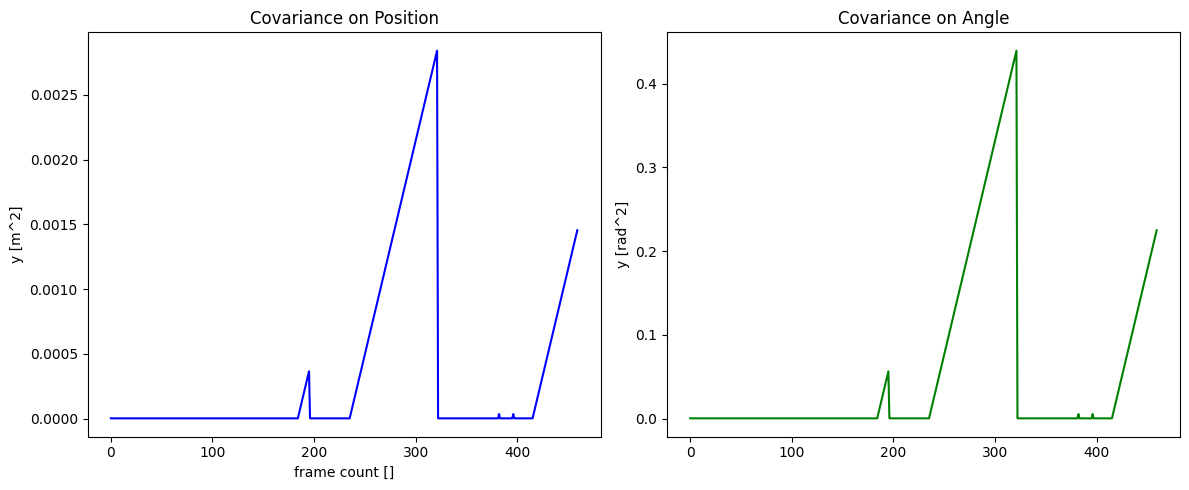

: 

In [ ]:
# to plot the variance of the position and the angle over time

x = range(0, frame_count)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 line, 2 columns

ax1.plot(x, stock_cov_pos, label='Covariance on position', color='blue')
ax1.set_xlabel('frame count')
ax1.set_ylabel('y [m^2]')
ax1.set_title('Covariance on Position')

ax2.plot(x, stock_cov_angle, label='Covariance on angle', color='green')
ax1.set_xlabel('frame count []')
ax2.set_ylabel('y [rad^2]') 
ax2.set_title('Covariance on Angle')

plt.tight_layout()

plt.show()

## Bibliography


<div id="ref1">[1]: https://docs.opencv.org/3.4/d3/dbe/tutorial_opening_closing_hats.html </div>
<div id="ref2">[2]: https://www.geeksforgeeks.org/python-opencv-connected-component-labeling-and-analysis/</div>
<div id="ref3">[3]: https://www.cs.cmu.edu/~coral/old/publinks/mmv/05sbai-juan.pdf</div>
<div id="ref4">[4]: https://www.zhinst.com/ch/de/resources/principles-of-pid-controllers </div>
<div id="ref5">[5]: “CS W4733 NOTES - Differential Drive Robots” complied from “Computational Principles of Mobile Robotics” by Dudek and Jenkin</div>
<div id="ref6">[6]: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/</div>
<div id="ref7">[7]: https://www.kalmanfilter.net/kalman1d.html</div>
<div id="ref8">[8]: Personal Laptop</div>
<div id="ref9">[9]: Personal Laptop</div>
